In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 

from matplotlib import pyplot as plt

semente = 1392734

# Importações de dados

## Hospital Sírio Libanes São Paulo

> Fonte: [Kaggle: COVID-19 - Clinical Data to assess diagnosis](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

In [2]:
url_sirio_lib = 'https://github.com/ConradBitt/BootCamp_DataScience/blob/master/ML%20em%20Saude/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'
sirio_libanes = pd.read_excel(url_sirio_lib)

## Leitos e Internações na cidade de São Paulo

> Fonte: [Fundação SEADE - CORONAVIRUS](https://www.seade.gov.br/coronavirus/#)

In [3]:
url_leitos_sp = 'https://raw.githubusercontent.com/ConradBitt/BootCamp_DataScience/master/projeto_final/dados/Leitos_e_Internacoes_sp.csv'
leitos_internacoes_sp = pd.read_csv(url_leitos_sp,sep=';', engine='python')

# Pré processamento

## Sírio Libanes

As informações referentes a base de dados do Sírio Libanês no Kaggle tem no total 1925 registros com 231 variáveis. Dessas variáveis 225 são quantitativas contínuas, 4 são quantitativas discretas e outras 2 variáveis são strings.

### Modificando `AGE_PERCENTIL`

A coluna `AGE_PERCENTIL` é categorica, que vai de 0 até 9 representando os percentis das idades. Por exemplo: 

* `AGE_PERCENTIL = 10th` idade de 0 até 10.

* `AGE_PERCENTIL = 20th` idade de 10 até 20.

*  `AGE_PERCENTIL = 30th` idade de 20 ...

* $....$

* `AGE_PERCENTIL = ABOVE 90th` idade de 90 até 100 

Por mais que seja uma variável categórica, ela é ordenável e se levarmos em conta o valor dela pode servir como um fator importante a ser considerado na estimativa se um indivíduo para a UTI ou não. Pois se o paciente tem entre 0 e 10 a a chance dele ir para a UTI é menor do que a do paciente que tem entre 10 e 20 anos.

Uma modificação que será feita é transformação do dado do tipo String `10,90th` para um dado do tipo inteiro `0-9`, além disso irei dividir por 10, afim de deixar os valores entre 0 e 1. Assim esta variável além de indicar os decis das idades de cada paciente também serve como um fator de espectativa. 

> *A expectativa $E$ de uma pessoa de idade $i$ ir pra UTI, é a probabilidade $P(x)$ de ir pra UTI vezes o fator da idade $i$:*

$$E (x) = i  P(x)$$

**Obs: $P(x)$ pode depender de vários fatores**

In [4]:
from sklearn.preprocessing import LabelEncoder

print(f'Percentil de idades categoricas antes :\n{sirio_libanes.AGE_PERCENTIL.unique()}')
le = LabelEncoder()
le.fit(sirio_libanes.AGE_PERCENTIL)
sirio_libanes.AGE_PERCENTIL = le.fit_transform(sirio_libanes.AGE_PERCENTIL) / 10
print(f'\nPercentil de idades categoricas depois:\n{sirio_libanes.AGE_PERCENTIL.unique()}')


Percentil de idades categoricas antes :
['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']

Percentil de idades categoricas depois:
[0.5 0.8 0.  0.3 0.6 0.1 0.4 0.7 0.2 0.9]


> perceba que se a pessoa tem entre 0 e 10 anos a variável $i$ assume valor $0.0$, logo a expectativa de que ela vá para a UTI é praticamente zero.

### Preenchendo dados do tipo `NaN`

Existem alguns registros cujo valor é `NaN` e como não temos informações  existem varias formas de preencher esses dados. É possível preencher com o anterior ou com o posterior, neste caso vou utilizar o método `.interpolate(method="linear")` do dataframe, para fazer uma interpolação linear caso esteja faltando apenas um valor e nos outros utilizarei a função `fillna()` com parâmetros `ffil` e depois `backfill`:

In [5]:
def interpolacao(grupo):
    return grupo.interpolate(method='linear')
    
def interpoLinear_ffill_backfill_valores_continuos(dataframe):
    # separa variaveis 
    colunas_features_categoricas = dataframe.iloc[:, :13].columns
    coluna_classificadores = dataframe.iloc[:,-2:].columns
    colunas_features_continuas = dataframe.iloc[:,13:-2].columns
    
    inicio_fataframe = dataframe[colunas_features_categoricas]
    fim_dataframe = dataframe[coluna_classificadores]
    
    #meio_dataframe = dataframe.groupby('PATIENT_VISIT_IDENTIFIER')[colunas_features_continuas].fillna(method='ffill').fillna(method='backfill')
    meio_dataframe = dataframe.groupby('PATIENT_VISIT_IDENTIFIER')[colunas_features_continuas].apply(interpolacao).fillna(method='ffill').fillna(method='backfill')
    
    dataframe = pd.concat([inicio_fataframe, meio_dataframe, fim_dataframe], axis='columns')
    
    return dataframe

In [6]:
sirio_libanes = interpoLinear_ffill_backfill_valores_continuos(sirio_libanes)

### Ajustando `PATIENT_VISIT_IDENTIFIER`

Uma dessas variáveis do tipo inteiro se chamada `PATIENT_VISIT_IDENTIFIER`, cuja função é armazenar várias informações de cada visita de um paciente tendo em vista que uma mesma pessoa pode ir mais de uma vez para o hospital. Dito isso, será feita uma seleção a fim de agrupar os dados de cada paciente e depois aplicar uma função chamada `foi_para_UTI()`.

In [7]:
def foi_para_UTI(grupo):
    """
    Se ICU no índice i é igual ao ICU índice i+1
        significa que não foi pra UTI,
        logo o dado é importante como informações do que não leva um paciente à UTI
        retorna toda a linha índice i + i
        
    Se ICU no indice i é diferente ao ICU indice i+1
        significa que o páciente foi pra UTI, precisamos das duas linhas para
        ter informação do que levou o paciente a unidade de terapia intensiva
        retorna as linhas UTI indice i e i + 1
    """
    
    if np.any(grupo['ICU']):
        for i in range(len(grupo['ICU'])):
            if grupo.iloc[i, -1] == grupo.iloc[i+1, -1]:
                retorno = grupo.iloc[i+1,:].to_frame().T
                return retorno

            elif grupo.iloc[i, -1] != grupo.iloc[i+1, -1]:
                retorno = grupo.iloc[i:i + 2,:] # i + 2 porque o slice é exclusive
                return retorno
                
            else:
                pass

In [8]:
dados_tratados = sirio_libanes.groupby('PATIENT_VISIT_IDENTIFIER').apply(foi_para_UTI)
dados_tratados = dados_tratados.drop('PATIENT_VISIT_IDENTIFIER', axis='columns').reset_index().iloc[:,2:]

In [9]:
def muda_variaveis_para_float64(dataframe):
    # separa variaveis 
    colunas_features_categoricas = dataframe.iloc[:, :13].columns
    coluna_classificadores = dataframe.iloc[:,-2:].columns
    colunas_features_continuas = dataframe.iloc[:,13:-2].columns
    
    inicio_fataframe = dataframe[colunas_features_categoricas].astype('float64')
    meio_dataframe = dataframe[colunas_features_continuas].astype('float64')
    fim_dataframe = dataframe[coluna_classificadores]
    
    dataframe = pd.concat([inicio_fataframe, meio_dataframe, fim_dataframe], axis='columns')
    
    return dataframe


In [10]:
dados_tratados = muda_variaveis_para_float64(dados_tratados)
dados_tratados.ICU = dados_tratados.ICU.astype('int64')
dados_tratados = dados_tratados.drop('WINDOW', axis='columns')

### Removendo variáveis altamente correlacionadas

Muitos das variáveis indicam a diferença de outras, por exemplo `TEMPERATURE` e `TEMPERATURE_DIFF`. Devido a uma variável estar relacionada com a outra a correlação entre elas é extremamente alta. Podemos ver a correlação de cada variável usando o mapa:

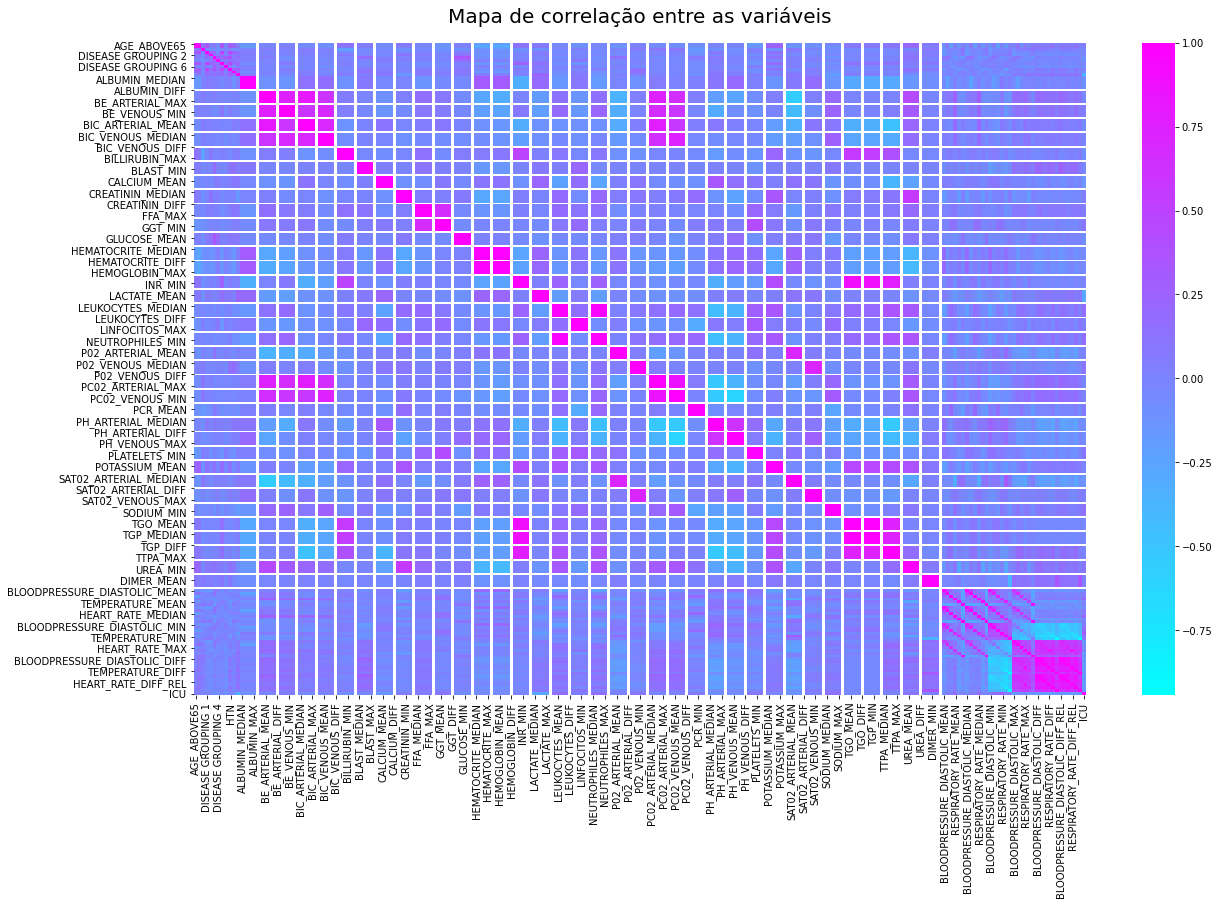

In [11]:
mapa = dados_tratados.corr()
plt.figure(figsize=(20,12))
ax = sns.heatmap(mapa, cmap='cool')
ax.set_title('Mapa de correlação entre as variáveis', fontsize=20, pad=20)
ax;

A fim de tirarb as variáveis altamente correlacionadas vou filtrar por um valor de corte. Todas as variáveis que tiverem uma correlação maior que 0.85, serão eliminadas.

In [12]:
def remove_variaveis_altamente_correlacionadas(dados, valor_corte):
    matriz_corr = dados.corr().abs()
    matriz_triangular_superior_booleana = np.triu(np.ones(matriz_corr.shape), k=1).astype('bool')
    matriz_trig_sup_corr = matriz_corr.where(matriz_triangular_superior_booleana)
    excluir_elemento = [coluna for coluna in matriz_trig_sup_corr.columns if any(matriz_trig_sup_corr[coluna] > valor_corte)]
    
    return dados.drop(excluir_elemento, axis='columns')

In [13]:
dados_tratados = remove_variaveis_altamente_correlacionadas(dados_tratados, 0.75)

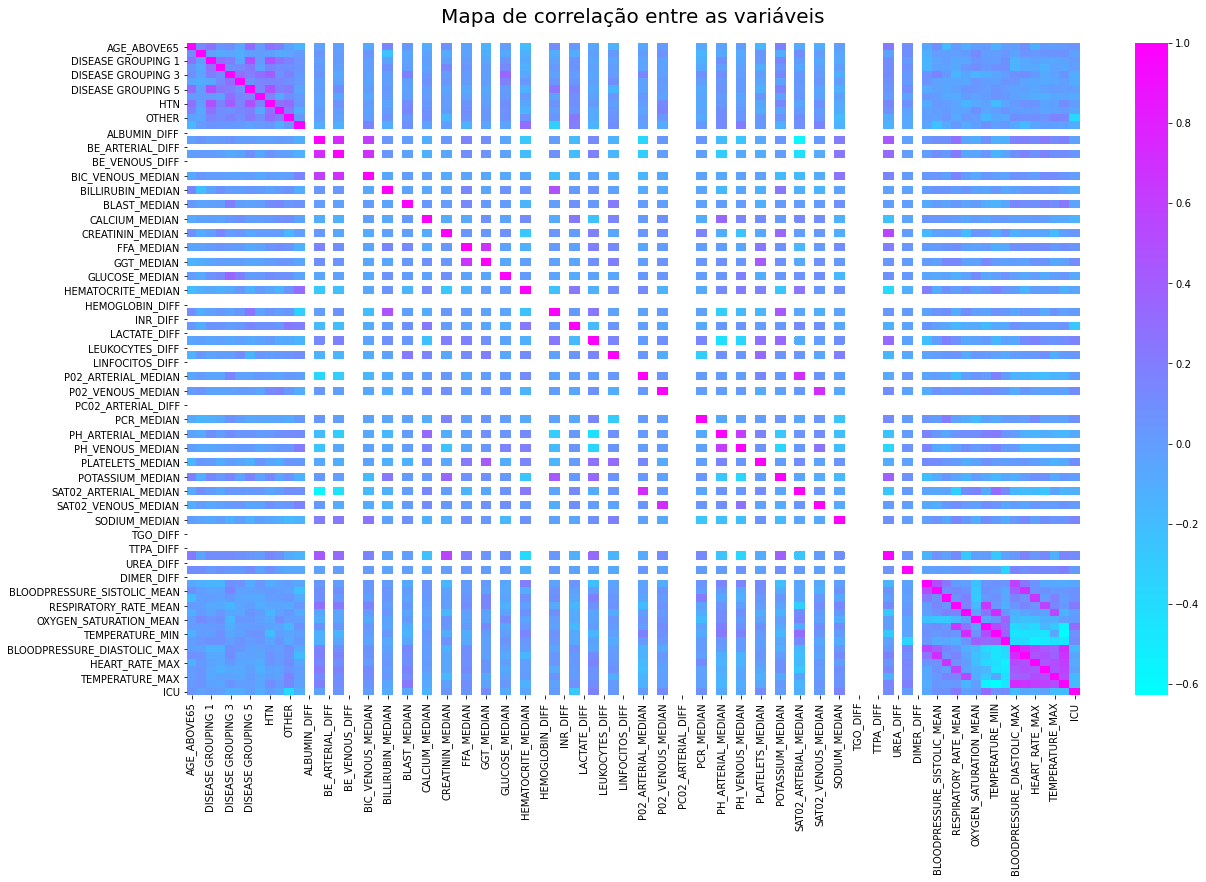

In [14]:
mapa = dados_tratados.corr()
plt.figure(figsize=(20,12))
ax = sns.heatmap(mapa, cmap='cool')
ax.set_title('Mapa de correlação entre as variáveis', fontsize=20, pad=20)
ax;

## Leitos cidade São Paulo

# Separando dados treino e teste

## Criando função pra facilitar comparação

In [50]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, StratifiedKFold
from statsmodels.stats.weightstats import ztest, zconfint
from scipy.stats import skewtest, kurtosistest, wilcoxon, ttest_ind
from sklearn.metrics import plot_roc_curve, roc_auc_score

"""
    Esta função roda um modelo utilizando uma técnica de cross validation.
    As metricas de qualidade podem ser passadas como parâmetros, por
    default será retirada as estatisticas. Também inclui testes de hipótese
    a respeito dos scores dos dados de treino e de teste.
    Os testes de hipótese são: 
        * Normalidade: Z test (statsmodels.stats.weightstats.ztest)
        * Simetria: Teste Skew (scipy.stats.skewtest)
        * Achatamento: Teste de Kurtose (scipy.stats.kurtosistest)
        * Distribuições: Wilcoxon, não paramétrico (scipy.stats.wilcoxon)
        * Comparação medias independentes: T teste independentes (scipy.stats.ttest_ind)
        
    return: Estatisticas descritivas e pvalores dos testes.
    
    se retornar_dados_brutos == True,
        retorna: dados brutos de treino e teste.
"""
    

def executa_modelo_com_cv(model, x, y, cv, scoring = 'roc_auc', random_state=None,
                          retornar_dados_brutos = False, retorna_modelo = False):
    
    seed = np.random.seed(random_state)
    
    if retorna_modelo:
        resultado_cross_validate = cross_validate(model, x, y = y, cv = cv, scoring=scoring, 
                                                  return_train_score = True,
                                                  return_estimator = retorna_modelo)
        
        resultado_cross_validate = pd.DataFrame(resultado_cross_validate)
        estimador = resultado_cross_validate['estimator'].iloc[-1]
        resultado_cross_validate = resultado_cross_validate.drop('estimator',axis='columns')
        
    else:
        resultado_cross_validate = cross_validate(model, x, y = y, cv = cv,
                                                  scoring = scoring,
                                                  return_train_score = True)
        
    resultados_brutos = pd.DataFrame(resultado_cross_validate)
    estatisticas_descritivas_model_cv = pd.DataFrame(resultado_cross_validate)
    
    intervalos_confianca = []
    pvalores_ztest = []
    pvalores_skew = []
    pvalores_kurtosis = []
    pvalores_wilcoxon = []
    pvalores_ttest_ind = []
    
    
    for variavel in resultados_brutos.columns:
        confintz = zconfint(resultados_brutos[variavel]) # logo podemos calcular zconfint
        intervalos_confianca.append(str(f'{np.array(confintz).round(2)}'))
        
        pvalor_ztest= ztest(resultados_brutos[variavel])
        pvalores_ztest.append(pvalor_ztest[1].round(3))
        
        pvalor_skew = skewtest(resultados_brutos[variavel])
        pvalores_skew.append(pvalor_skew[1].round(5))
        
        pvalor_kurtosis = kurtosistest(resultados_brutos[variavel])
        pvalores_kurtosis.append(pvalor_kurtosis[1].round(5))
        
        
        pvalor_wilcoxon = wilcoxon(x=resultados_brutos['test_score'],y=resultados_brutos['train_score'], zero_method='zsplit')
        pvalores_wilcoxon.append(pvalor_wilcoxon[1].round(5))
        
        
        pvalor_ttest_ind = ttest_ind(a=resultados_brutos['test_score'],b=resultados_brutos['train_score'])
        pvalores_ttest_ind.append(pvalor_ttest_ind[1].round(5))
        
        
        
    estatisticas_descritivas_model_cv = pd.DataFrame(resultado_cross_validate).describe().T
    estatisticas_descritivas_model_cv['conf_int'] = intervalos_confianca
    estatisticas_descritivas_model_cv['Ztest'] = pvalores_ztest
    estatisticas_descritivas_model_cv['skew'] = pvalores_skew
    estatisticas_descritivas_model_cv['kurtosis'] = pvalores_kurtosis
    estatisticas_descritivas_model_cv['Wilcoxon'] = pvalores_wilcoxon
    estatisticas_descritivas_model_cv['Ttest_ind'] = pvalores_ttest_ind
    
    
    if retornar_dados_brutos:
        return resultados_brutos
    if retorna_modelo:
        return estatisticas_descritivas_model_cv, estimador
    
    return estatisticas_descritivas_model_cv.iloc[-2:,:]


def executa_modelos(modelos : dict, x, y, tecnica_cv, scoring, random_state = None,
                    retorna_resultados_brutos = False, retorna_modelos = False,
                    exibe_plot_roc = False, exibicoes = True):
    
    seed = np.random.seed(random_state)
    resultados_brutos = {}
    
    x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify=y, random_state=seed)
    
    estimadores = {}
    resultados = {}
    
    for nome_modelo, modelo in modelos.items():

        if retorna_modelos:
            resultado_descritivo, estimador = executa_modelo_com_cv(modelo, x, y, cv = tecnica_cv,
                                                                    scoring=scoring,random_state=seed,
                                                                    retorna_modelo = retorna_modelos)
            resultado_descritivo = resultado_descritivo.iloc[-2:,:]
            estimadores[nome_modelo] = estimador
            
        else:
            resultado_descritivo = executa_modelo_com_cv(modelo, x, y, cv = tecnica_cv,
                                                         scoring=scoring,random_state=seed).iloc[-2:,:]
            

        resultados_brutos[nome_modelo] = executa_modelo_com_cv(modelo, x, y, cv = tecnica_cv,
                                                                    scoring=scoring,random_state=seed,
                                                                    retornar_dados_brutos=True)
        if exibicoes:
            print(20*'____')
            print('\nModelo:'+'\033[34m'+f' {nome_modelo}'+'\033[0;0m',end='\t')
            print(f'Métrica de qualidade: \033[32m {scoring.upper()} \033[0;0m', end='\t')
            print('Técnica CV: '+'\033[32m'+f'{str(tecnica_cv).split("(")[0]}'+'\033[0;0m')
            display(resultado_descritivo.round(3))
            resultados[nome_modelo] = resultado_descritivo
    
    if exibe_plot_roc:
        if exibicoes:
            f, ax = plt.subplots(2, 2,figsize=(15,12))

            plot_roc_curve(estimadores['DecisionTreeClassifier'], x_teste, y_teste, ax = ax[0,0]).ax_.set_title('DecisionTreeClassifier', fontsize=18)
            plot_roc_curve(estimadores['LogisticRegression'], x_teste, y_teste,ax=ax[0,1]).ax_.set_title('LogisticRegression', fontsize=18)
            plot_roc_curve(estimadores['SGDClassifier'], x_teste, y_teste, ax=ax[1,0]).ax_.set_title('SGDClassifier', fontsize=18);
            plot_roc_curve(estimadores['LinearSVC'], x_teste, y_teste, ax=ax[1,1]).ax_.set_title('LinearSVC', fontsize=18);
            plt.show()

    if retorna_resultados_brutos:
        return resultados_brutos
    
    if retorna_modelos:
        return resultados, estimadores
    
    else:
        return resultados

## Instanciando Modelos

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

dummy_class = DummyClassifier(strategy='most_frequent',random_state=semente)
decision_tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=semente)
logistic = LogisticRegression(solver='newton-cg')
sgd_class = SGDClassifier(loss='log', eta0 = 0.8, learning_rate='adaptive', random_state=semente)
linear_svc = LinearSVC(max_iter=50000, loss='hinge',random_state=semente, dual=True)

modelos = {'DummyClassifier' : dummy_class,
           'DecisionTreeClassifier' : decision_tree,
           'LogisticRegression' : logistic,
           'SGDClassifier': sgd_class,
           'LinearSVC' : linear_svc}

## Resultados

Aqui eu vou separar os dados em dois grupos: 

* **Dados para o modelo. Esse são para treinar e testar usando validação cruzada**

* **Dados para validação. Esses são para validar a qualidade do modelo em dados que nunca viu antes. Por mais que a técnica `RepeatedStratifiedKFold` faça essa validação, como é repetido várias vezes corre o risco de um overfitting **

In [52]:
dados_embaralhados = dados_tratados.sample(frac=1, random_state=semente)

dados_para_modelo = dados_embaralhados.iloc[:180,:]
dados_para_validacao = dados_embaralhados.iloc[180:, :]

x = dados_para_modelo.iloc[:,:-1]
y = dados_para_modelo.iloc[:,-1]

x_validacao = dados_para_validacao.iloc[:,:-1]
y_validacao = dados_para_validacao.iloc[:,-1]


### Usando a técnica RepeatedStratifiedKFold

A técnica `RepeatedStratifiedKFold` estratifica os dados em dados de treino e teste, além disso separa alguns dados fora desse ciclo para realizar a validação. 

/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/conrado/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:744: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff


________________________________________________________________________________

Modelo: DummyClassifier	Métrica de qualidade:  F1 	Técnica CV: RepeatedStratifiedKFold


/home/conrado/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:744: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0. 0.],NaN,0.3,0.0,1.0,NaN
train_score,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0. 0.],NaN,0.3,0.0,1.0,NaN


________________________________________________________________________________

Modelo: DecisionTreeClassifier	Métrica de qualidade:  F1 	Técnica CV: RepeatedStratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,36.0,0.344,0.155,0.000,0.277,0.358,0.462,0.600,[0.29 0.39],0.0,0.167,0.818,0.0,0.0
train_score,36.0,0.769,0.059,0.625,0.732,0.764,0.822,0.854,[0.75 0.79],0.0,0.345,0.625,0.0,0.0


________________________________________________________________________________

Modelo: LogisticRegression	Métrica de qualidade:  F1 	Técnica CV: RepeatedStratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,36.0,0.454,0.135,0.143,0.361,0.462,0.56,0.714,[0.41 0.5 ],0.0,0.440,0.956,0.0,0.0
train_score,36.0,0.609,0.048,0.493,0.587,0.611,0.63,0.737,[0.59 0.62],0.0,0.649,0.229,0.0,0.0


________________________________________________________________________________

Modelo: SGDClassifier	Métrica de qualidade:  F1 	Técnica CV: RepeatedStratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,36.0,0.481,0.122,0.250,0.375,0.488,0.576,0.706,[0.44 0.52],0.0,0.648,0.083,0.0,0.0
train_score,36.0,0.740,0.031,0.682,0.720,0.734,0.759,0.800,[0.73 0.75],0.0,0.463,0.406,0.0,0.0


________________________________________________________________________________

Modelo: LinearSVC	Métrica de qualidade:  F1 	Técnica CV: RepeatedStratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,36.0,0.472,0.123,0.250,0.400,0.466,0.560,0.706,[0.43 0.51],0.0,0.812,0.193,0.0,0.0
train_score,36.0,0.690,0.038,0.623,0.665,0.696,0.717,0.756,[0.68 0.7 ],0.0,0.555,0.098,0.0,0.0


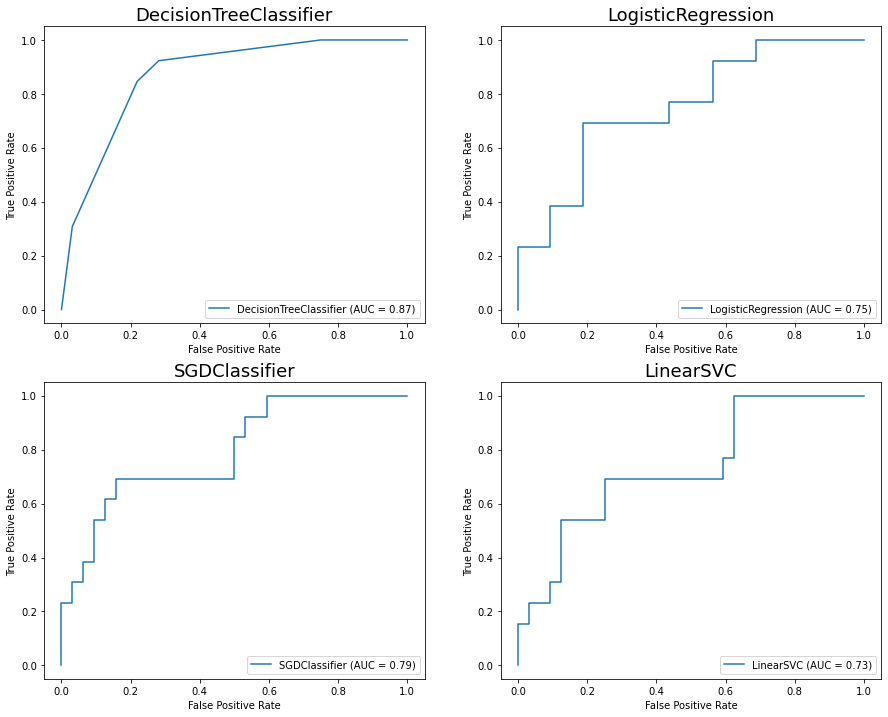

/home/conrado/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:744: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff
/home/conrado/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:744: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff


________________________________________________________________________________

Modelo: DummyClassifier	Métrica de qualidade:  F1 	Técnica CV: StratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0. 0.],NaN,0.299,0.0,1.0,NaN
train_score,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0. 0.],NaN,0.299,0.0,1.0,NaN


________________________________________________________________________________

Modelo: DecisionTreeClassifier	Métrica de qualidade:  F1 	Técnica CV: StratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.353,0.404,0.000,0.000,0.000,0.667,1.00,[0.21 0.49],0.0,0.248,0.000,0.0,0.0
train_score,32.0,0.761,0.043,0.658,0.741,0.762,0.790,0.83,[0.75 0.78],0.0,0.083,0.566,0.0,0.0


________________________________________________________________________________

Modelo: LogisticRegression	Métrica de qualidade:  F1 	Técnica CV: StratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.346,0.325,0.000,0.000,0.500,0.667,1.000,[0.23 0.46],0.0,0.892,0.00,0.003,0.0
train_score,32.0,0.591,0.019,0.554,0.578,0.588,0.606,0.636,[0.58 0.6 ],0.0,0.590,0.97,0.003,0.0


________________________________________________________________________________

Modelo: SGDClassifier	Métrica de qualidade:  F1 	Técnica CV: StratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.403,0.373,0.00,0.00,0.500,0.667,1.000,[0.27 0.53],0.0,0.687,0.000,0.001,0.0
train_score,32.0,0.725,0.023,0.66,0.71,0.725,0.738,0.777,[0.72 0.73],0.0,0.793,0.187,0.001,0.0


________________________________________________________________________________

Modelo: LinearSVC	Métrica de qualidade:  F1 	Técnica CV: StratifiedKFold


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.408,0.325,0.000,0.000,0.500,0.667,1.000,[0.3 0.52],0.0,0.689,0.012,0.0,0.0
train_score,32.0,0.663,0.025,0.622,0.643,0.663,0.681,0.716,[0.65 0.67],0.0,0.434,0.370,0.0,0.0


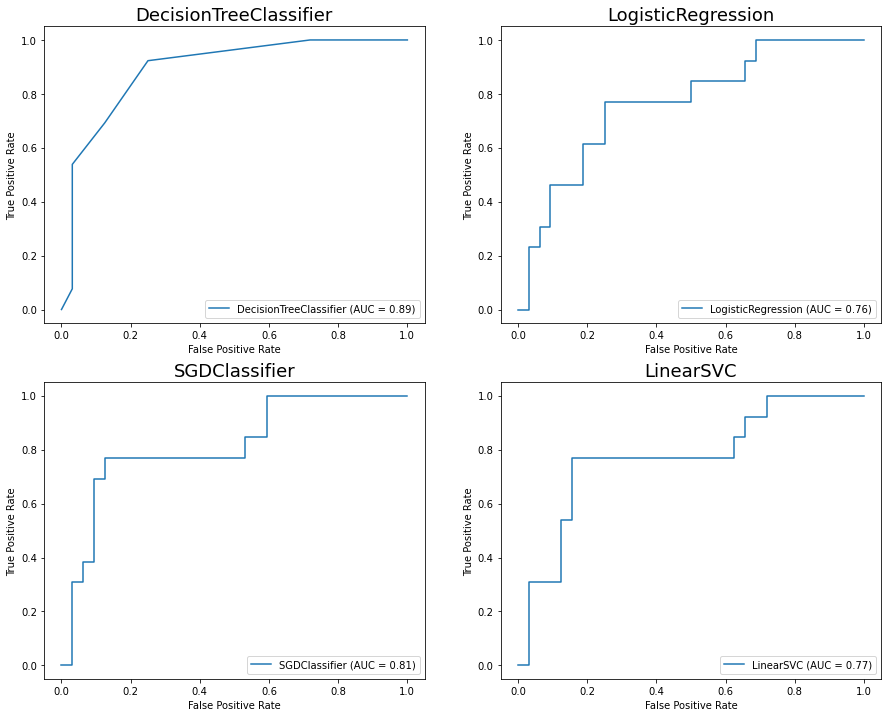

________________________________________________________________________________

Modelo: DummyClassifier	Métrica de qualidade:  F1 	Técnica CV: StratifiedShuffleSplit


/home/conrado/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:744: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff
/home/conrado/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:744: RuntimeWarning: invalid value encountered in double_scalars
  zstat = (value1 - value2 - diff) / std_diff


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0. 0.],NaN,0.299,0.0,1.0,NaN
train_score,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[0. 0.],NaN,0.299,0.0,1.0,NaN


________________________________________________________________________________

Modelo: DecisionTreeClassifier	Métrica de qualidade:  F1 	Técnica CV: StratifiedShuffleSplit


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.277,0.233,0.000,0.000,0.286,0.411,0.800,[0.2 0.36],0.0,0.415,0.331,0.0,0.0
train_score,32.0,0.748,0.052,0.567,0.729,0.760,0.785,0.813,[0.73 0.77],0.0,0.001,0.009,0.0,0.0


________________________________________________________________________________

Modelo: LogisticRegression	Métrica de qualidade:  F1 	Técnica CV: StratifiedShuffleSplit


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.395,0.204,0.000,0.277,0.422,0.545,0.727,[0.32 0.47],0.0,0.153,0.895,0.0,0.0
train_score,32.0,0.618,0.040,0.545,0.595,0.616,0.645,0.714,[0.6 0.63],0.0,0.437,0.566,0.0,0.0


________________________________________________________________________________

Modelo: SGDClassifier	Métrica de qualidade:  F1 	Técnica CV: StratifiedShuffleSplit


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.445,0.172,0.000,0.344,0.481,0.571,0.727,[0.39 0.5 ],0.0,0.243,0.825,0.0,0.0
train_score,32.0,0.726,0.028,0.653,0.708,0.729,0.745,0.771,[0.72 0.74],0.0,0.168,0.487,0.0,0.0


________________________________________________________________________________

Modelo: LinearSVC	Métrica de qualidade:  F1 	Técnica CV: StratifiedShuffleSplit


,count,mean,std,min,25%,50%,75%,max,conf_int,Ztest,skew,kurtosis,Wilcoxon,Ttest_ind
test_score,32.0,0.420,0.206,0.000,0.277,0.444,0.600,0.727,[0.35 0.49],0.0,0.148,0.552,0.0,0.0
train_score,32.0,0.686,0.038,0.619,0.659,0.689,0.711,0.761,[0.67 0.7 ],0.0,0.687,0.319,0.0,0.0


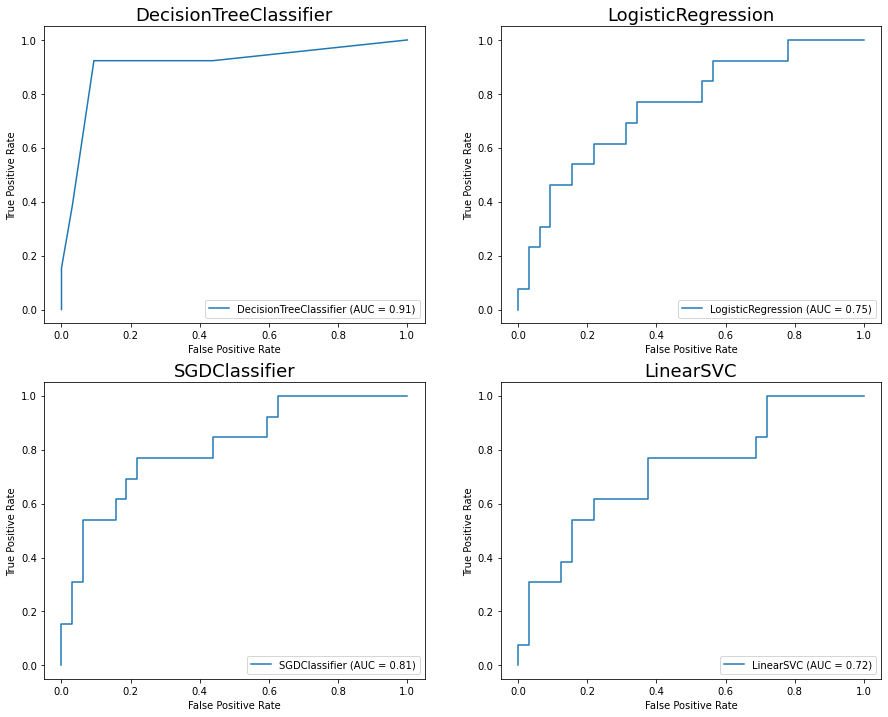

In [53]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit

RSKF = RepeatedStratifiedKFold(n_splits=6,n_repeats=6, random_state=semente)
SKF = StratifiedKFold(n_splits=32, random_state=semente)
SSS = StratifiedShuffleSplit(n_splits=32, random_state=semente)

tecnicas_cv = {'RSKF':RSKF, 'SKF': SKF, 'SSS':SSS}

for nome_tecnica, tecnica in tecnicas_cv.items():
    
    resultados, estimadores = executa_modelos(modelos, x, y, scoring='f1',
                                          tecnica_cv=tecnica, random_state=semente,
                                          retorna_modelos=True,exibe_plot_roc=True,)

#### Comentario sobre validação cruzada 

Acima em cada tabela temos os valores das estatisticas descritivas da validação cruzada, tendo em vista que separamos em 5 grupos e realizamos o treino, teste e validação 10, temos um total de 50 resultados e dele extraimos as estatisticas descritivas e alguns testes estatisticos. 

Pode-se

In [41]:
for nome_modelo, modelo in estimadores.items():
    if nome_modelo != 'LinearSVC':
        y_predito = modelo.predict_proba(x_validacao)
        auc_score = roc_auc_score(y_validacao, y_predito[:,1])
        
        print(20*'_____')
        print(f'Modelo:\t \033[34m{nome_modelo}\033[0;0m\t\t|AUC Score na validacao: {auc_score:.5f}')
        print(20*'_____')
        display(resultados[nome_modelo].iloc[:,:-5])
        

____________________________________________________________________________________________________
Modelo:	 DummyClassifier		|AUC Score na validacao: 0.50000
____________________________________________________________________________________________________


,count,mean,std,min,25%,50%,75%,max,conf_int
test_score,36.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,[0.5 0.5]
train_score,36.0,0.5,0.0,0.5,0.5,0.5,0.5,0.5,[0.5 0.5]


____________________________________________________________________________________________________
Modelo:	 DecisionTreeClassifier		|AUC Score na validacao: 0.77778
____________________________________________________________________________________________________


,count,mean,std,min,25%,50%,75%,max,conf_int
test_score,36.0,0.60196,0.121914,0.349206,0.512566,0.600078,0.697962,0.886243,[0.56 0.64]
train_score,36.0,0.93789,0.018448,0.902766,0.922947,0.937577,0.949762,0.973306,[0.93 0.94]


____________________________________________________________________________________________________
Modelo:	 LogisticRegression		|AUC Score na validacao: 0.85648
____________________________________________________________________________________________________


,count,mean,std,min,25%,50%,75%,max,conf_int
test_score,36.0,0.727016,0.077171,0.513228,0.679518,0.742529,0.779101,0.846561,[0.7 0.75]
train_score,36.0,0.890279,0.013690,0.865137,0.881915,0.888911,0.899124,0.917667,[0.89 0.89]


____________________________________________________________________________________________________
Modelo:	 SGDClassifier		|AUC Score na validacao: 0.82407
____________________________________________________________________________________________________


,count,mean,std,min,25%,50%,75%,max,conf_int
test_score,36.0,0.681990,0.082381,0.507937,0.615079,0.695767,0.752413,0.814815,[0.66 0.71]
train_score,36.0,0.907377,0.012155,0.881861,0.898436,0.906625,0.915955,0.930746,[0.9 0.91]


#### Conclusões sobre o treinamento

Pode-se verificar que temos uma situação de overfitting, isso porque a validação esta fora da do intervalo de confiança informado nos dados de teste da validação cruzada.

In [ ]:
leitos_internacoes_sp.head()

In [ ]:
leitos_internacoes_sp['datahora'] = pd.to_datetime(leitos_internacoes_sp['datahora'])

In [ ]:
leitos_internacoes_sp['ocupacao_leitos'].rolling(10).mean().plot()

Criar um modelo linear que tente estimar a quantidade de leitos, na forma: 

$$ \bar{y} = \text{MM}_{\text{leitos}} + \sum\hat{E}(x),$$

onde $\bar{y}$ é a quantidade de leitos estimada, $\text{MM}_{\text{leitos}}$ a média móvel de leitos na cidade de São Paulo e $\hat{E}(x)$ o valor estimado em cima dos valores de validação
> se vai pra UTI soma 1, se não zero, pra um dia.
> O valo